<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [205]:
%%javascript
// ToC script
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [204]:
#Code hider, source: http://chris-said.io/2016/02/13/how-to-make-polished-jupyter-presentations-with-optional-code-visibility/
from IPython.display import HTML

HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
''')



# Imports and utils

In [52]:
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import multiprocessing
import pingouin as pg
from uszipcode import SearchEngine

import utils.lifesense_utils as ls_utils

from multiprocessing import Pool

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

%matplotlib inline

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning:

The package pingouin is out of date. Your version is 0.3.3, the latest is 0.3.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.



In [2]:
ema_file_prefix = "/data/tliu/wave2_aggregate/2020-05-13/"
vad_file_loc = "/data/tliu/vad_aggregate/2020-05-15/pdk-voice-activity/{}.df"

In [3]:
def wk_assignment(date):
    if (date >= pd.to_datetime('2020-02-11')) & (date < pd.to_datetime('2020-02-18')):
        return 'wk1'
    elif (date >= pd.to_datetime('2020-03-03')) & (date < pd.to_datetime('2020-03-10')):
        return 'wk4'
    elif (date >= pd.to_datetime('2020-03-24')) & (date < pd.to_datetime('2020-03-31')):
        return 'wk7'
    elif (date >= pd.to_datetime('2020-04-14')) & (date < pd.to_datetime('2020-04-21')):
        return 'wk10'
    elif (date >= pd.to_datetime('2020-05-05')) & (date < pd.to_datetime('2020-05-12')):
        return 'wk13'
    else:
        return np.nan


# VAD label processing

In [4]:
pids = []
wave2_id_file_loc = "/home/tliu/lifesense/wave2_data/wave2_wk4_ids.txt"
with open(wave2_id_file_loc, "r") as wave_f:
    for line in wave_f.readlines():
        pids.append(line.strip())

## Extract voice relationship columns

In [5]:
def extract_voice_rel_df(ema_df, pid):
    """Extracts voice relationship data from EMA dataframes.
    
    Args:
        pid (str): the participant id
        ema_df (pd.DataFrame): an evening_ema or evening_phq8 survey DataFrame
    
    Returns:
        voice_df (pd.DataFrame):
            pid (str)
            relationship (str)
            start_timestamp (int)
            start_time (pd.DateTime)
            end_timestamp (int)
            end_time (pd.DateTime)
            duration (pd.TimeDelta)
    """

    voice_cols = ema_df.columns[ema_df.columns.str.contains('voice')].tolist()
    df_dict = {
        "relationship": [],
        "start_timestamp": [],
        "start_time": [],
        "end_timestamp": [],
        "end_time": [],
        "duration": [],
        "timezone-offset": []
    }
    for col in voice_cols:

        # extract relationship string
        relation_str = ""
        if "other" in col:
            relation_str += "other"

        rel_val = ema_df[col][~ema_df[col].isna()].iloc[0].strip("[]")
        rel_split = rel_val.split('_')
        if rel_split[0] == "relationship":
            rel_split.pop(0)
        relation_str += "_".join(rel_split)

        # strip any leading or trailing whitespace
        relation_str = relation_str.strip()    
        
        # extract start and end times: last two elements of the col
        col_split = col.split("_")
        start_time = int(col_split[-2])
        end_time = int(col_split[-1])
        tz_offset = ema_df['timezone-offset'][~ema_df[col].isna()].iloc[0]
        # populate df_dict
        df_dict['relationship'].append(relation_str)
        df_dict['start_timestamp'].append(start_time)
        df_dict['start_time'].append(pd.to_datetime(start_time, unit="ms") + pd.Timedelta(tz_offset, unit='s'))
        df_dict['end_timestamp'].append(end_time)
        df_dict['end_time'].append(pd.to_datetime(end_time, unit="ms") + pd.Timedelta(tz_offset, unit='s'))
        df_dict['duration'].append(pd.to_timedelta(end_time - start_time, unit="ms"))
        df_dict['timezone-offset'].append(tz_offset)
    voice_df = pd.DataFrame.from_dict(df_dict)
    voice_df['pid'] = pid
    return voice_df

### Evening PHQ extraction

In [6]:
voice_df = pd.DataFrame()

In [7]:
phq_file_loc = ema_file_prefix + "{}_phq8/{}.df"

time_of_days = ['morning', 'evening']

for pid in pids:
    for tod in time_of_days:
        df = pd.read_pickle(phq_file_loc.format(tod, pid))
        if df.shape[0] > 0:
            v_df = extract_voice_rel_df(df, pid)
            voice_df = voice_df.append(v_df, sort=True)

### Evening EMA extraction

In [8]:
ema_file_loc = ema_file_prefix + "{}_ema/{}.df"

time_of_days = ['evening']

for pid in pids:
    for tod in time_of_days:
        df = pd.read_pickle(ema_file_loc.format(tod, pid))
        if df.shape[0] > 0:
            v_df = extract_voice_rel_df(df, pid)
            voice_df = voice_df.append(v_df, sort=True)

In [9]:
voice_df.shape

(25245, 8)

In [10]:
voice_df.head()

,duration,end_time,end_timestamp,pid,relationship,start_time,start_timestamp,timezone-offset
0,01:25:00.114000,2020-02-16 19:00:06.759,1.581908e+12,14673820,acquaintance,2020-02-16 17:35:06.645,1.581903e+12,-28800.0
1,00:15:00.011000,2020-02-16 20:15:06.805,1.581913e+12,14673820,acquaintance,2020-02-16 20:00:06.794,1.581912e+12,-28800.0
2,00:10:00.005000,2020-02-16 21:00:06.838,1.581916e+12,14673820,family_live_away,2020-02-16 20:50:06.833,1.581915e+12,-28800.0
3,00:10:00.006000,2020-02-16 22:10:08.567,1.581920e+12,14673820,friend,2020-02-16 22:00:08.561,1.581919e+12,-28800.0
4,00:10:02.986000,2020-02-17 01:55:19.359,1.581933e+12,14673820,friend,2020-02-17 01:45:16.373,1.581933e+12,-28800.0


In [11]:
voice_df['start_date'] = voice_df['start_time'].dt.normalize()
voice_df['study_wk'] = voice_df['start_date'].apply(wk_assignment)

In [12]:
voice_df['study_wk'].value_counts()

wk4     6431
wk1     5719
wk7     5292
wk10    3938
wk13    3739
Name: study_wk, dtype: int64

In [13]:
voice_df['start_date'].value_counts().sort_index()

2020-02-11     818
2020-02-12     814
2020-02-13     752
2020-02-14     739
2020-02-15    1037
2020-02-16     858
2020-02-17     701
2020-02-18      30
2020-02-24       8
2020-03-03     983
2020-03-04     939
2020-03-05     895
2020-03-06     925
2020-03-07     918
2020-03-08     863
2020-03-09     908
2020-03-11      10
2020-03-24     931
2020-03-25     646
2020-03-26     806
2020-03-27     770
2020-03-28     769
2020-03-29     750
2020-03-30     620
2020-03-31      30
2020-04-02      10
2020-04-14     619
2020-04-15     576
2020-04-16     591
2020-04-17     563
2020-04-18     599
2020-04-19     490
2020-04-20     500
2020-04-21      12
2020-04-22       6
2020-05-04      14
2020-05-05     648
2020-05-06     560
2020-05-07     555
2020-05-08     558
2020-05-09     497
2020-05-10     479
2020-05-11     442
2020-05-12       6
Name: start_date, dtype: int64

# VAD Dataframe

## Process DataFrame

In [14]:
%%time


def extract_vad_df(vad_df, pid):
    """Extracts vad data from raw VAD dataframes.
    
    Args:
        pid (str): the participant id
        ema_df (pd.DataFrame): a raw VAD dataframe
    
    Returns:
        voice_df (pd.DataFrame):
            pid (str)
            start_timestamp (int)
            start_time (pd.DateTime)
            end_timestamp (int)
            end_time (pd.DateTime)
            duration (pd.TimeDelta)
    """
    df_dict = {
        "start_timestamp": [],
        "start_time": [],
        "end_timestamp": [],
        "end_time": [],
        "duration": [],
        "timezone-offset": []
    }

    start_ts = None
    start_tz = None
    end_ts = None
    for idx, row in vad_df.iterrows():
        if (start_ts is None) and row['voices_present']:
            start_ts = row['timestamp']
            start_tz = row['timezone-offset']
        # we've reached the end of a "voices present" section
        if (start_ts is not None) and not row['voices_present']:
            end_ts = row['timestamp']
                        
            # populate dictionary
            df_dict['start_timestamp'].append(start_ts)
            df_dict['start_time'].append(pd.to_datetime(start_ts + start_tz, unit="s"))
            df_dict['end_timestamp'].append(end_ts)
            df_dict['end_time'].append(pd.to_datetime(end_ts + start_tz, unit="s"))
            df_dict['duration'].append(pd.to_timedelta(end_ts - start_ts, unit="s"))
            df_dict['timezone-offset'].append(start_tz)

            # reset indices
            start_ts = None
            start_tz = None
            end_ts = None

    process_vad_df = pd.DataFrame.from_dict(df_dict)
    process_vad_df['pid'] = pid
    
    return process_vad_df

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs


In [15]:
%%time
test_pid = "01515998"

vad_df = pd.read_pickle(vad_file_loc.format(test_pid))
vad_df = extract_vad_df(vad_df, test_pid)

CPU times: user 3.43 s, sys: 28 ms, total: 3.46 s
Wall time: 3.46 s


In [16]:
%%time 

f_args = []

for pid in pids:
    f_args.append((pd.read_pickle(vad_file_loc.format(pid)), pid))

with multiprocessing.Pool(8) as pool:
    results = pool.starmap(extract_vad_df, f_args)

CPU times: user 7.24 s, sys: 2.46 s, total: 9.7 s
Wall time: 1min 1s


In [17]:
all_vad_df = pd.DataFrame()

for df in results:
    all_vad_df = all_vad_df.append(df)

In [18]:
all_vad_df['start_date'] = all_vad_df['start_time'].dt.normalize()
all_vad_df['study_wk'] = all_vad_df['start_date'].apply(wk_assignment)

# Validate Unlabelled and Labelled Voice Activity

In [19]:
study_voice_df = voice_df[~voice_df['study_wk'].isna()]
# drop "other" only relationships for duplicates
study_voice_df = study_voice_df[study_voice_df['relationship'] != 'other']
print(study_voice_df.shape)
print(voice_df.shape)

(12557, 10)
(25245, 10)


In [20]:
study_vad_df = all_vad_df[~all_vad_df['study_wk'].isna()]

print(study_vad_df.shape)
print(all_vad_df.shape)

(83973, 9)
(229893, 9)


In [21]:
%%time

test_pid = "14673820"

sel_vad_df = study_vad_df[study_vad_df['pid'] == test_pid]
sel_voice_df = study_voice_df[(study_voice_df['pid'] == test_pid)]
has_voice_label = []

for idx, row in sel_vad_df.iterrows():
    print(row['start_time'])
    print(row['end_time'])
    
    labeled_sum = 0
    slice_voice_df = sel_voice_df[(sel_voice_df['start_time'] >= row['start_time']) &
                                  (sel_voice_df['end_time'] <= row['end_time'])]
    
    print(slice_voice_df.shape)
    
    

2020-02-11 13:51:22
2020-02-11 13:55:21
(0, 10)
2020-02-11 13:56:21
2020-02-11 13:57:21
(0, 10)
2020-02-11 14:02:21
2020-02-11 14:03:21
(0, 10)
2020-02-11 14:04:21
2020-02-11 14:05:21
(0, 10)
2020-02-11 14:14:21
2020-02-11 14:15:21
(0, 10)
2020-02-11 14:24:21
2020-02-11 14:25:21
(0, 10)
2020-02-11 14:26:22
2020-02-12 01:32:31
(0, 10)
2020-02-12 01:37:31
2020-02-12 02:02:31
(0, 10)
2020-02-12 02:07:31
2020-02-12 02:48:09
(0, 10)
2020-02-12 02:54:11
2020-02-12 13:51:08
(3, 10)
2020-02-12 14:01:08
2020-02-12 14:11:09
(0, 10)
2020-02-12 14:16:10
2020-02-12 16:16:12
(2, 10)
2020-02-12 16:21:12
2020-02-12 16:41:11
(0, 10)
2020-02-12 16:46:12
2020-02-12 18:29:19
(0, 10)
2020-02-12 18:34:19
2020-02-12 18:53:12
(0, 10)
2020-02-12 18:58:42
2020-02-12 19:10:00
(0, 10)
2020-02-12 19:18:01
2020-02-12 22:41:07
(0, 10)
2020-02-12 22:51:08
2020-02-12 23:06:08
(0, 10)
2020-02-12 23:11:09
2020-02-12 23:16:09
(0, 10)
2020-02-12 23:26:08
2020-02-13 01:11:29
(0, 10)
2020-02-13 01:18:00
2020-02-13 02:33:48


(0, 10)
2020-03-08 06:10:28
2020-03-08 06:20:32
(0, 10)
2020-03-08 06:35:30
2020-03-08 06:48:01
(0, 10)
2020-03-08 07:00:28
2020-03-08 07:07:01
(0, 10)
2020-03-08 07:21:01
2020-03-08 07:26:44
(0, 10)
2020-03-08 07:32:00
2020-03-08 07:56:04
(0, 10)
2020-03-08 08:10:08
2020-03-08 12:00:09
(0, 10)
2020-03-08 12:05:12
2020-03-08 12:20:09
(0, 10)
2020-03-08 12:50:29
2020-03-08 19:40:14
(3, 10)
2020-03-08 19:45:14
2020-03-08 20:10:14
(0, 10)
2020-03-08 20:15:14
2020-03-08 20:40:13
(0, 10)
2020-03-08 21:05:40
2020-03-08 22:20:48
(0, 10)
2020-03-08 22:26:28
2020-03-09 00:00:51
(1, 10)
2020-03-09 00:10:51
2020-03-09 00:25:51
(0, 10)
2020-03-09 00:30:51
2020-03-09 01:41:40
(0, 10)
2020-03-09 01:45:53
2020-03-09 03:05:53
(0, 10)
2020-03-09 03:15:53
2020-03-09 03:25:52
(0, 10)
2020-03-09 03:30:53
2020-03-09 03:35:52
(0, 10)
2020-03-09 03:40:52
2020-03-09 03:55:52
(0, 10)
2020-03-09 04:05:53
2020-03-09 07:36:07
(0, 10)
2020-03-09 07:41:06
2020-03-09 08:31:20
(0, 10)
2020-03-09 08:36:15
2020-03-09 0

(0, 10)
2020-03-28 15:32:01
2020-03-28 16:06:25
(0, 10)
2020-03-28 16:11:26
2020-03-28 19:59:25
(2, 10)
2020-03-28 20:04:25
2020-03-28 20:14:25
(0, 10)
2020-03-28 20:19:26
2020-03-28 23:29:25
(2, 10)
2020-03-28 23:39:26
2020-03-28 23:49:25
(0, 10)
2020-03-28 23:54:26
2020-03-29 00:09:25
(0, 10)
2020-03-29 00:14:25
2020-03-29 00:56:15
(0, 10)
2020-03-29 01:01:15
2020-03-29 01:22:17
(0, 10)
2020-03-29 01:32:02
2020-03-29 01:37:49
(0, 10)
2020-03-29 01:41:25
2020-03-29 01:47:52
(0, 10)
2020-03-29 01:57:20
2020-03-29 02:47:49
(0, 10)
2020-03-29 02:52:14
2020-03-29 03:38:01
(0, 10)
2020-03-29 03:42:12
2020-03-29 04:37:08
(0, 10)
2020-03-29 04:42:22
2020-03-29 05:58:27
(0, 10)
2020-03-29 06:25:30
2020-03-29 06:28:27
(0, 10)
2020-03-29 06:54:15
2020-03-29 07:00:09
(0, 10)
2020-03-29 07:08:56
2020-03-29 07:14:20
(0, 10)
2020-03-29 07:32:24
2020-03-29 07:42:22
(0, 10)
2020-03-29 07:52:22
2020-03-29 10:12:45
(0, 10)
2020-03-29 10:17:46
2020-03-29 10:42:49
(0, 10)
2020-03-29 10:47:49
2020-03-29 1

(0, 10)
2020-04-18 15:14:15
2020-04-18 15:19:14
(0, 10)
2020-04-18 16:29:23
2020-04-18 17:44:23
(0, 10)
2020-04-18 18:29:31
2020-04-18 19:50:25
(0, 10)
2020-04-18 19:55:26
2020-04-18 20:15:25
(0, 10)
2020-04-18 21:10:26
2020-04-18 21:22:16
(0, 10)
2020-04-18 21:51:49
2020-04-18 21:55:53
(0, 10)
2020-04-18 22:20:32
2020-04-18 23:20:32
(0, 10)
2020-04-18 23:25:33
2020-04-18 23:55:32
(0, 10)
2020-04-19 00:05:32
2020-04-19 00:50:32
(0, 10)
2020-04-19 01:00:33
2020-04-19 01:30:41
(0, 10)
2020-04-19 01:35:35
2020-04-19 04:50:50
(0, 10)
2020-04-19 04:55:50
2020-04-19 05:36:38
(0, 10)
2020-04-19 05:41:35
2020-04-19 06:02:02
(0, 10)
2020-04-19 06:07:39
2020-04-19 06:41:49
(0, 10)
2020-04-19 06:47:02
2020-04-19 06:52:42
(0, 10)
2020-04-19 06:56:58
2020-04-19 07:08:00
(0, 10)
2020-04-19 07:13:01
2020-04-19 07:52:54
(0, 10)
2020-04-19 07:56:45
2020-04-19 08:11:52
(0, 10)
2020-04-19 08:17:01
2020-04-19 09:16:11
(0, 10)
2020-04-19 09:22:03
2020-04-19 10:16:41
(0, 10)
2020-04-19 10:21:39
2020-04-19 1

### Compute amount of VAD time actually labelled

In [22]:
label_sum = study_voice_df.groupby(["pid", "start_date"], as_index=False)['duration'].sum()
unlabel_sum = study_vad_df.groupby(["pid", "start_date"], as_index=False)['duration'].sum()

In [23]:
vad_sums = unlabel_sum.merge(label_sum, on=['pid', 'start_date'], how='left')
# for now, clamp to a day
vad_sums[vad_sums['duration_x'] < pd.Timedelta(1, unit='d')]
vad_sums.head()

,pid,start_date,duration_x,duration_y
0,01515998,2020-02-11,0 days 04:51:45,NaT
1,01515998,2020-02-12,1 days 04:27:05,01:29:57.192000
2,01515998,2020-02-13,0 days 07:51:50,01:35:03.269000
3,01515998,2020-02-14,0 days 13:46:36,NaT
4,01515998,2020-02-15,0 days 18:52:40,02:39:58.770000


In [24]:
vad_sums['sum_ratio'] = vad_sums['duration_y'] / vad_sums['duration_x']

count    3009.000000
mean        0.088348
std         0.085576
min         0.002343
25%         0.040577
50%         0.066677
75%         0.106585
max         0.981565
Name: sum_ratio, dtype: float64

Text(0.5, 1.0, 'Ratio of unlabelled VAD voice present time and labelled VAD time')

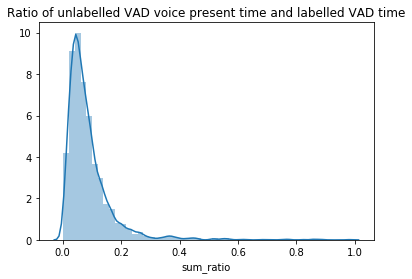

In [25]:
sel_df = vad_sums[vad_sums['sum_ratio'] < 1]
display(sel_df['sum_ratio'].describe())
sns.distplot(sel_df['sum_ratio'])
plt.title("Ratio of unlabelled VAD voice present time and labelled VAD time")

# Cross-reference with semantic location

In [26]:
sel_voice_df.head()

,duration,end_time,end_timestamp,pid,relationship,start_time,start_timestamp,timezone-offset,start_date,study_wk
0,01:25:00.114000,2020-02-16 19:00:06.759,1.581908e+12,14673820,acquaintance,2020-02-16 17:35:06.645,1.581903e+12,-28800.0,2020-02-16,wk1
1,00:15:00.011000,2020-02-16 20:15:06.805,1.581913e+12,14673820,acquaintance,2020-02-16 20:00:06.794,1.581912e+12,-28800.0,2020-02-16,wk1
2,00:10:00.005000,2020-02-16 21:00:06.838,1.581916e+12,14673820,family_live_away,2020-02-16 20:50:06.833,1.581915e+12,-28800.0,2020-02-16,wk1
3,00:10:00.006000,2020-02-16 22:10:08.567,1.581920e+12,14673820,friend,2020-02-16 22:00:08.561,1.581919e+12,-28800.0,2020-02-16,wk1
4,00:10:02.986000,2020-02-17 01:55:19.359,1.581933e+12,14673820,friend,2020-02-17 01:45:16.373,1.581933e+12,-28800.0,2020-02-17,wk1


In [27]:
# load semantic location "raw"
sloc_loc = ema_file_prefix + "/semantic-location/{}.df"
sel_slocs = pd.read_pickle(sloc_loc.format(test_pid))
sel_slocs['place-kind-fmt'] = sel_slocs['place-kind'].map(ls_utils.sloc_map)
sel_slocs['place-kind-fmt'] = sel_slocs['place-kind-fmt'].fillna("n/a")

In [28]:
sel_slocs.head()

,pid,date,time,latitude,longitude,place-kind,place-kind-fmt
0,14673820,2020-02-04,2020-02-04 17:47:00,33.8105,-118.297,Errand,errand
1,14673820,2020-02-04,2020-02-04 17:52:00,33.8105,-118.297,Errand,errand
2,14673820,2020-02-04,2020-02-04 17:58:00,33.812,-118.297,Errand,errand
3,14673820,2020-02-04,2020-02-04 18:05:57,33.8319,-118.289,Food and Drink,food
4,14673820,2020-02-04,2020-02-04 18:08:34,33.832,-118.289,Food and Drink,food


In [29]:
sel_slocs['place-kind-fmt'].isna().sum()

0

In [30]:
%%time
sloc_loc = ema_file_prefix + "/semantic-location/{}.df"
slocs = [x for x in ls_utils.sloc_map.values()]

def get_sloc_voice_df(voice_df, pid):
    """Uses semantic-location DataFrames to calculate location durations of conversations
    
    Args:
        voice_df (pd.DataFrame): df containing labelled conversations
        pid (str): participant id
    
    Returns:
        combined_df (pd.DataFrame): df with selected labelled conversations and durations at semantic locations
    """
    # filter and format sloc and voice dfs
    sel_voice_df = voice_df[voice_df['pid'] == pid]
    sel_voice_df = sel_voice_df.reset_index(drop=True)

    sel_slocs = pd.read_pickle(sloc_loc.format(pid))
    if (sel_slocs is None) or (sel_voice_df.shape[0] == 0):
        return None
    sel_slocs['place-kind-fmt'] = sel_slocs['place-kind'].map(ls_utils.sloc_map)
    sel_slocs['place-kind-fmt'] = sel_slocs['place-kind-fmt'].fillna("n/a")
    sel_slocs = sel_slocs.reset_index(drop=True)
    
    # outer dict, for the new df columns
    df_dict = {k: [] for k in ls_utils.sloc_map.values()}
    
    for idx, voice_row in sel_voice_df.iterrows():
        sloc_slice = sel_slocs[(sel_slocs['time'] >= voice_row['start_time']) & (sel_slocs['time'] <= voice_row['end_time'])]

        # inner dict, for each sloc duration
        dur_dict = {k: pd.Timedelta(0, unit='s') for k in ls_utils.sloc_map.values()}
        
        if sloc_slice.shape[0] > 0:
            sloc_slice = sloc_slice.sort_values(by='time')

            # initialize start time and loc to beginning of the conversation and previously recorded loc
            start_loc = sel_slocs.iloc[sloc_slice.index[0] - 1]['place-kind-fmt']
            start_time = voice_row['start_time']
            
            for _, sloc_row in sloc_slice.iterrows():
                cur_loc = sloc_row['place-kind-fmt']
                cur_time = sloc_row['time']

                # participant has switched locations
                if start_loc != cur_loc:
                    duration = (cur_time - start_time)#.total_seconds()

                    dur_dict[start_loc] += duration
                    start_loc = cur_loc
                    start_time = cur_time

            # at the bottom of the slice, assume that the participant is at the last location until end of convo
            duration = (voice_row['end_time'] - start_time)#.total_seconds()
            dur_dict[start_loc] += duration

        # populate df_dict
        for loc, dur in dur_dict.items():
            df_dict[loc].append(dur)


    dur_df = pd.DataFrame.from_dict(df_dict)

    # sanity check: the semantic durations should never be more than the total conversation duration
    combined_df = pd.concat([sel_voice_df, dur_df], axis=1)
    combined_df['sloc_total'] = combined_df[slocs].sum(axis=1)
    assert (combined_df['sloc_total'] > combined_df['duration']).sum() == 0
    
    return combined_df

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 10.5 µs


In [31]:
%%time
f_args = [(study_voice_df, pid) for pid in pids]

with multiprocessing.Pool(12) as pool:
    sloc_results = pool.starmap(get_sloc_voice_df, f_args)

CPU times: user 690 ms, sys: 400 ms, total: 1.09 s
Wall time: 5.07 s


In [32]:
len(sloc_results)

138

## Semantic Location Analysis

In [33]:
sloc_voice = pd.DataFrame()

for df in sloc_results:
    sloc_voice = sloc_voice.append(df)

In [34]:
sloc_voice['sloc_total'].describe()

count                     12420
mean     0 days 00:17:45.889695
std      0 days 00:32:07.826321
min             0 days 00:00:00
25%      0 days 00:10:00.006000
50%      0 days 00:10:01.997000
75%      0 days 00:20:00.018000
max      0 days 22:59:05.347000
Name: sloc_total, dtype: object

In [35]:
relationships = [
    "spouse_partner",
    "media_source",
    "family_member",
    "friend",
    "work",
    "family_live_away",
    "acquaintance",
    "other",
    "none"
]

In [36]:
sloc_voice['relationship'].value_counts().head(10)

spouse_partner                                2141
media_source                                  1859
none                                          1846
family_member                                 1688
friend                                        1602
work                                           772
family_live_away                               528
acquaintance                                   295
spouse_partner, relationship_family_member     234
none, relationship_media_source                175
Name: relationship, dtype: int64

In [37]:
# process relationships
rel_df = pd.DataFrame()
for rel in relationships:
    rel_df["relationship_" + rel] = (sloc_voice['relationship'].str.contains(rel)).astype(int)

In [38]:
sloc_voice = pd.concat([sloc_voice, rel_df], axis=1)

### FacetGrids

#### Total Duration

(0, 100)

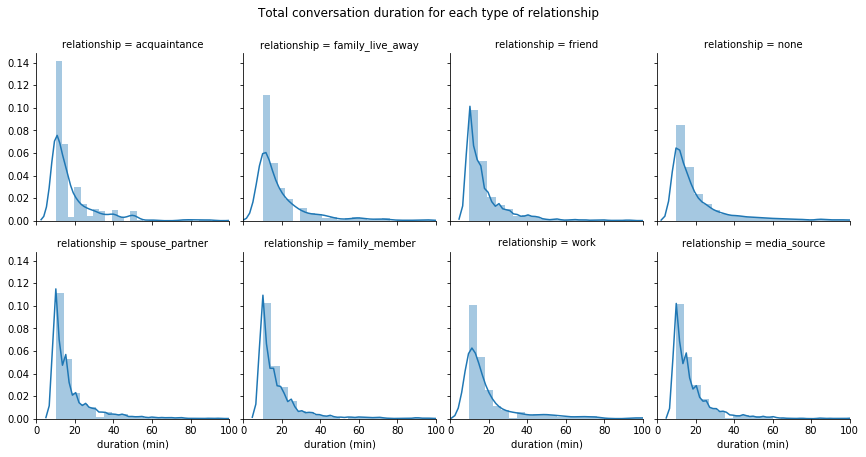

In [41]:
# limit to single relationship conversations
sel_df = sloc_voice[sloc_voice['relationship'].isin(relationships)]
sel_df = sel_df[sel_df['duration'] < pd.Timedelta(4, unit="hr")]
sel_df['duration (min)'] = sel_df['duration'].dt.total_seconds() / 60
g = sns.FacetGrid(sel_df, col="relationship", col_wrap=4)
g = g.map(sns.distplot, "duration (min)")
plt.suptitle("Total conversation duration for each type of relationship", y=1.05)
plt.xlim(0,100)

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/seaborn/axisgrid.py:728: UserWarning:

Using the boxplot function without specifying `order` is likely to produce an incorrect plot.



(0, 100)

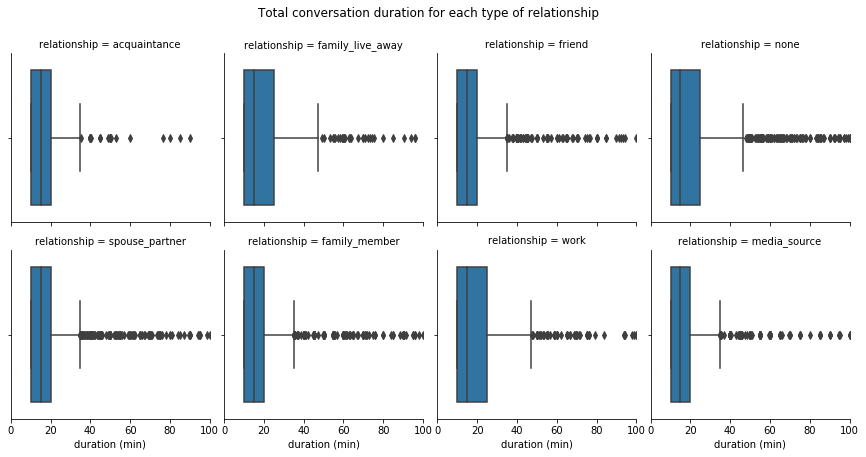

In [42]:
# limit to single relationship conversations
sel_df = sloc_voice[sloc_voice['relationship'].isin(relationships)]
sel_df = sel_df[sel_df['duration'] < pd.Timedelta(4, unit="hr")]
sel_df['duration (min)'] = sel_df['duration'].dt.total_seconds() / 60
g = sns.FacetGrid(sel_df, col="relationship", col_wrap=4)
g = g.map(sns.boxplot, "duration (min)")
plt.suptitle("Total conversation duration for each type of relationship", y=1.05)
plt.xlim(0,100)

In [125]:
rel_cols = ['relationship_' + rel for rel in relationships]
loc_cols = ['location_' + loc for loc in slocs[:-2]]
sel_corr = sloc_voice[slocs + rel_cols]

for loc in slocs[:-2]:
    sel_corr['location_' + loc] = sel_corr[loc].dt.total_seconds()
sel_corr = sel_corr[loc_cols + rel_cols]


/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Text(0.5, 1, 'Spearman correlations between conversation duration type and semantic location duration')

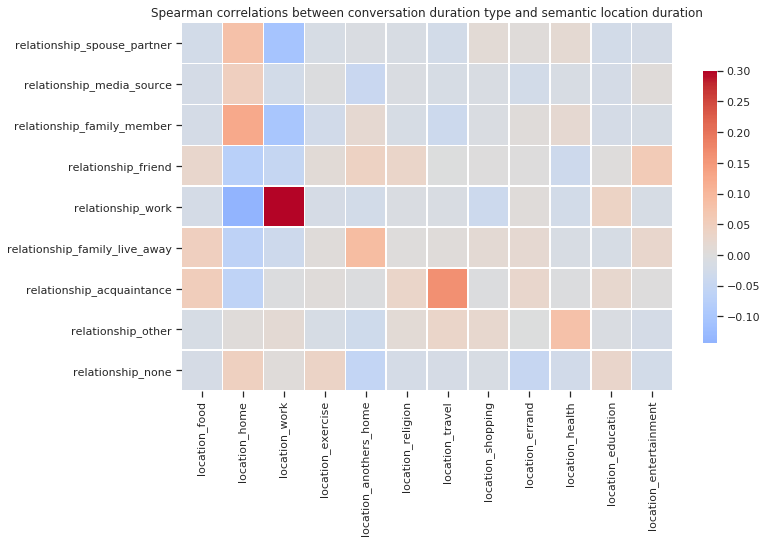

In [126]:
corr = sel_corr.corr(method='spearman')
corr = corr.iloc[len(slocs[:-2]):, :len(slocs[:-2])]

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap='coolwarm', center=0, vmax=0.3,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Spearman correlations between conversation duration type and semantic location duration")

In [147]:
# sel_corr_count = sel_corr.clip(lower=0, upper=1)
# corr = sel_corr_count.corr(method='spearman')
# corr = corr.iloc[len(slocs[:-2]):, :len(slocs[:-2])]

# # Set up the matplotlib figure
# f, ax = plt.subplots(figsize=(11, 10))

# Generate a custom diverging colormap
# cmap = sns.diverging_palette(220, 10, as_cmap=True)

# # Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corr, cmap='coolwarm', center=0, vmax=0.3,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})
# plt.title("Spearman correlations between conversation type and semantic location count")

### FacetGrid drilldowns at specific locations

#### Home

(0, 100)

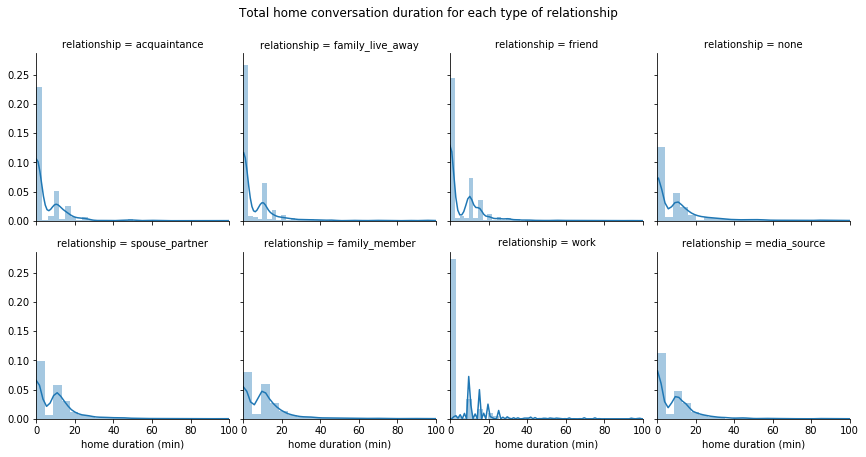

In [45]:
# limit to single relationship conversations
sel_df = sloc_voice[sloc_voice['relationship'].isin(relationships)]
sel_df = sel_df[sel_df['duration'] < pd.Timedelta(4, unit="hr")]
sel_df['home duration (min)'] = sel_df['home'].dt.total_seconds() / 60
g = sns.FacetGrid(sel_df, col="relationship", col_wrap=4)
g = g.map(sns.distplot, "home duration (min)")
plt.suptitle("Total home conversation duration for each type of relationship", y=1.05)
plt.xlim(0,100)

#### Work

(0, 40)

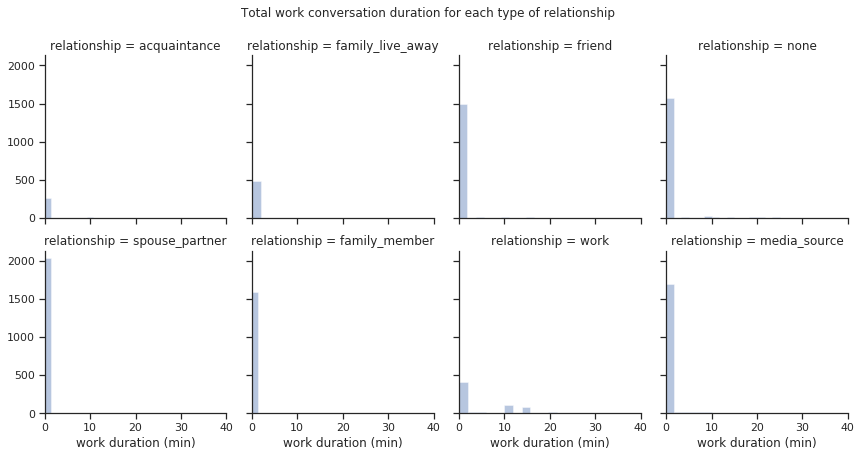

In [98]:
# limit to single relationship conversations
sel_df = sloc_voice[sloc_voice['relationship'].isin(relationships)]
sel_df = sel_df[sel_df['duration'] < pd.Timedelta(1, unit="hr")]
sel_df['work duration (min)'] = sel_df['work'].dt.total_seconds() / 60
g = sns.FacetGrid(sel_df, col="relationship", col_wrap=4)
g = g.map(sns.distplot, "work duration (min)",  kde=False, bins=30)
plt.suptitle("Total work conversation duration for each type of relationship", y=1.05)
plt.xlim(0,40)

# Correlation with EMAs

In [131]:
# load latest ema
ema_loc = "/home/tliu/covid-anxiety/data/ema.df"
emas = ['stress', 'mood', 'energetic', 'distracted']

ema_df = pd.read_pickle(ema_loc)

# reverse code for negative valence high
for ema in emas:
    ema_df[ema] = 8 - ema_df[ema]

ema_df = ema_df.groupby(['pid', 'date'], as_index=False)[emas].mean()

## Counts, one participant-day per row

Text(0.5, 1, 'Spearman correlations between conversation type count and daily EMA')

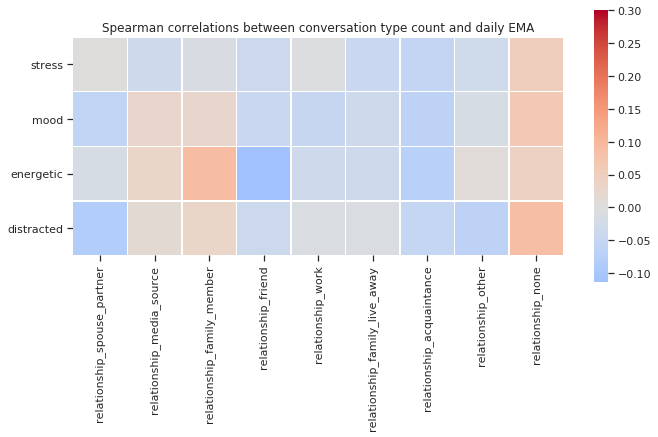

In [196]:
# Get daily aggregates of conversation lengths, and counts
convo_count = sloc_voice.groupby(["pid", "start_date"], as_index=False)[rel_cols].sum(axis=1)
convo_count = convo_count.rename({"start_date": "date"}, axis='columns')

convo_count = convo_count.merge(ema_df, on=['pid', 'date'], how='left')
corr = convo_count.corr(method='spearman')
corr = corr.iloc[len(rel_cols):, :len(rel_cols)]

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap='coolwarm', center=0, vmax=0.3,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.yticks(rotation=0)
plt.title("Spearman correlations between conversation type count and daily EMA")

In [197]:
count_corr_details = pg.pairwise_corr(data=convo_count, method="spearman", padjust="fdr_bh")
count_corr_details[count_corr_details['Y'].isin(emas) & (count_corr_details['p-corr'] < 0.05) & (~count_corr_details['X'].isin(emas))]

,X,Y,method,tail,n,r,CI95%,r2,adj_r2,z,p-unc,p-corr,p-adjust,power
9,relationship_spouse_partner,mood,spearman,two-sided,3078,-0.056,"[-0.09, -0.02]",0.003,0.002,-0.056,1.888304e-03,5.078886e-03,fdr_bh,0.875
11,relationship_spouse_partner,distracted,spearman,two-sided,3077,-0.082,"[-0.12, -0.05]",0.007,0.006,-0.082,4.732996e-06,1.943019e-05,fdr_bh,0.996
31,relationship_family_member,energetic,spearman,two-sided,3077,0.090,"[0.05, 0.12]",0.008,0.007,0.090,5.690941e-07,2.774334e-06,fdr_bh,0.999
39,relationship_friend,mood,spearman,two-sided,3078,-0.043,"[-0.08, -0.01]",0.002,0.001,-0.043,1.765572e-02,3.825405e-02,fdr_bh,0.660
40,relationship_friend,energetic,spearman,two-sided,3077,-0.114,"[-0.15, -0.08]",0.013,0.012,-0.114,2.497355e-10,1.498413e-09,fdr_bh,1.000
47,relationship_work,mood,spearman,two-sided,3078,-0.049,"[-0.08, -0.01]",0.002,0.002,-0.049,6.488432e-03,1.488523e-02,fdr_bh,0.777
53,relationship_family_live_away,stress,spearman,two-sided,3077,-0.042,"[-0.08, -0.01]",0.002,0.001,-0.042,2.043681e-02,4.194923e-02,fdr_bh,0.640
59,relationship_acquaintance,stress,spearman,two-sided,3077,-0.052,"[-0.09, -0.02]",0.003,0.002,-0.052,3.846909e-03,9.679320e-03,fdr_bh,0.824
60,relationship_acquaintance,mood,spearman,two-sided,3078,-0.064,"[-0.1, -0.03]",0.004,0.003,-0.064,3.987461e-04,1.110793e-03,fdr_bh,0.943
61,relationship_acquaintance,energetic,spearman,two-sided,3077,-0.073,"[-0.11, -0.04]",0.005,0.005,-0.073,4.505519e-05,1.673479e-04,fdr_bh,0.983


## Conversation duration, one participant-day per row

### Pearson

Text(0.5, 1, 'Pearson correlations between conversation type duration and daily EMA')

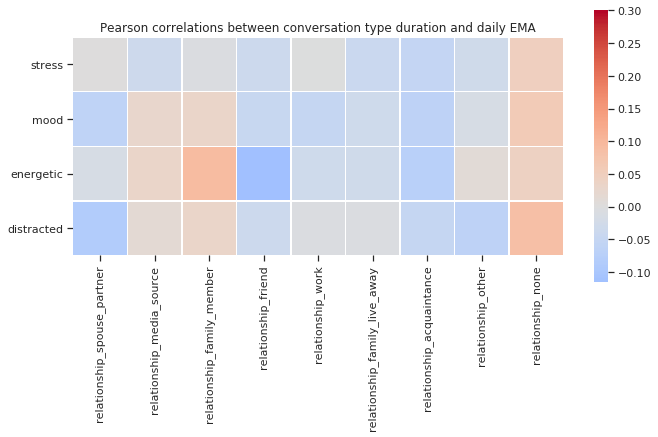

In [198]:
convo_dur = sloc_voice.copy()
for rel in rel_cols:
    convo_dur[rel] = (convo_dur[rel] * convo_dur['duration']).dt.total_seconds() / 60

convo_dur = convo_dur.groupby(["pid", "start_date"], as_index=False)[rel_cols].sum(axis=1)
convo_dur = convo_dur.rename({"start_date": "date"}, axis='columns')

convo_dur = convo_dur.merge(ema_df, on=['pid', 'date'], how='left')
corr = convo_dur.corr(method='spearman')
corr = corr.iloc[len(rel_cols):, :len(rel_cols)]

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap="coolwarm", center=0, vmax=0.3,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.yticks(rotation=0)
plt.title("Pearson correlations between conversation type duration and daily EMA")

In [199]:
dur_corr_details = pg.pairwise_corr(data=convo_dur, method="pearson", padjust="fdr_bh")
dur_corr_details[(dur_corr_details['Y'].isin(emas)) & (dur_corr_details['p-corr'] < 0.05) & (~dur_corr_details['X'].isin(emas))]

,X,Y,method,tail,n,r,CI95%,r2,adj_r2,z,p-unc,p-corr,p-adjust,BF10,power
9,relationship_spouse_partner,mood,pearson,two-sided,3078,-0.044,"[-0.08, -0.01]",0.002,0.001,-0.044,0.014701,0.047779,fdr_bh,0.442,0.684
19,relationship_media_source,stress,pearson,two-sided,3077,-0.048,"[-0.08, -0.01]",0.002,0.002,-0.048,0.007431,0.028981,fdr_bh,0.811,0.764
31,relationship_family_member,energetic,pearson,two-sided,3077,0.064,"[0.03, 0.1]",0.004,0.003,0.064,0.000366,0.001903,fdr_bh,12.881,0.946
40,relationship_friend,energetic,pearson,two-sided,3077,-0.052,"[-0.09, -0.02]",0.003,0.002,-0.052,0.004047,0.016615,fdr_bh,1.404,0.820
61,relationship_acquaintance,energetic,pearson,two-sided,3077,-0.056,"[-0.09, -0.02]",0.003,0.003,-0.056,0.001766,0.008609,fdr_bh,2.994,0.879


### spearman

Text(0.5, 1, 'spearman correlations between conversation type duration and daily EMA')

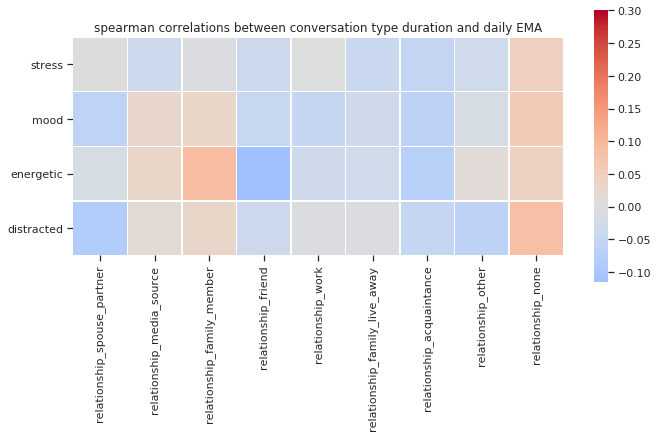

In [200]:
convo_dur = sloc_voice.copy()
for rel in rel_cols:
    convo_dur[rel] = (convo_dur[rel] * convo_dur['duration']).dt.total_seconds() / 60

convo_dur = convo_dur.groupby(["pid", "start_date"], as_index=False)[rel_cols].sum(axis=1)
convo_dur = convo_dur.rename({"start_date": "date"}, axis='columns')

convo_dur = convo_dur.merge(ema_df, on=['pid', 'date'], how='left')
corr = convo_dur.corr(method='spearman')
corr = corr.iloc[len(rel_cols):, :len(rel_cols)]

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap="coolwarm", center=0, vmax=0.3,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.yticks(rotation=0)
plt.title("spearman correlations between conversation type duration and daily EMA")

In [201]:
dur_corr_details = pg.pairwise_corr(data=convo_dur, method="spearman", padjust="fdr_bh")
dur_corr_details[(dur_corr_details['Y'].isin(emas)) & (dur_corr_details['p-corr'] < 0.05) & (~dur_corr_details['X'].isin(emas))]

,X,Y,method,tail,n,r,CI95%,r2,adj_r2,z,p-unc,p-corr,p-adjust,power
9,relationship_spouse_partner,mood,spearman,two-sided,3078,-0.061,"[-0.1, -0.03]",0.004,0.003,-0.061,6.800273e-04,2.040082e-03,fdr_bh,0.925
11,relationship_spouse_partner,distracted,spearman,two-sided,3077,-0.084,"[-0.12, -0.05]",0.007,0.006,-0.084,3.361099e-06,1.379820e-05,fdr_bh,0.996
31,relationship_family_member,energetic,spearman,two-sided,3077,0.093,"[0.06, 0.13]",0.009,0.008,0.093,2.712332e-07,1.322262e-06,fdr_bh,0.999
39,relationship_friend,mood,spearman,two-sided,3078,-0.045,"[-0.08, -0.01]",0.002,0.001,-0.045,1.184965e-02,2.567423e-02,fdr_bh,0.711
40,relationship_friend,energetic,spearman,two-sided,3077,-0.116,"[-0.15, -0.08]",0.013,0.013,-0.117,1.288362e-10,7.730174e-10,fdr_bh,1.000
47,relationship_work,mood,spearman,two-sided,3078,-0.050,"[-0.08, -0.01]",0.002,0.002,-0.050,5.975969e-03,1.369382e-02,fdr_bh,0.785
59,relationship_acquaintance,stress,spearman,two-sided,3077,-0.052,"[-0.09, -0.02]",0.003,0.002,-0.052,3.756810e-03,9.452620e-03,fdr_bh,0.826
60,relationship_acquaintance,mood,spearman,two-sided,3078,-0.064,"[-0.1, -0.03]",0.004,0.003,-0.064,3.794750e-04,1.286915e-03,fdr_bh,0.945
61,relationship_acquaintance,energetic,spearman,two-sided,3077,-0.074,"[-0.11, -0.04]",0.005,0.005,-0.074,4.072124e-05,1.588128e-04,fdr_bh,0.984
62,relationship_acquaintance,distracted,spearman,two-sided,3077,-0.050,"[-0.09, -0.01]",0.002,0.002,-0.050,5.571552e-03,1.316912e-02,fdr_bh,0.792


## Counts, one participant per row

Text(0.5, 1, 'Spearman correlations between conversation type count and daily EMA, per participant')

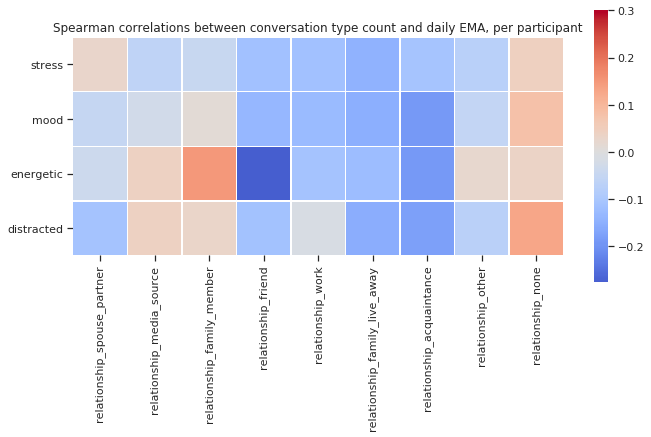

In [190]:
# Get daily aggregates of conversation lengths, and counts
convo_count = sloc_voice.groupby(["pid", "start_date"], as_index=False)[rel_cols].sum(axis=1)
convo_count = convo_count.rename({"start_date": "date"}, axis='columns')

convo_count = convo_count.merge(ema_df, on=['pid', 'date'], how='left')
convo_count.drop("date", axis='columns', inplace=True)
convo_count = convo_count.groupby("pid").mean()
corr = convo_count.corr(method='spearman')
corr = corr.iloc[len(rel_cols):, :len(rel_cols)]

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap='coolwarm', center=0, vmax=0.3,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.yticks(rotation=0)
plt.title("Spearman correlations between conversation type count and daily EMA, per participant")

In [191]:
count_corr_details = pg.pairwise_corr(data=convo_count, method="spearman", padjust="fdr_bh")
count_corr_details[(count_corr_details['Y'].isin(emas)) & (count_corr_details['p-corr'] < 0.05) & (~count_corr_details['X'].isin(emas))]

,X,Y,method,tail,n,r,CI95%,r2,adj_r2,z,p-unc,p-corr,p-adjust,power
40,relationship_friend,energetic,spearman,two-sided,136,-0.276,"[-0.42, -0.11]",0.076,0.062,-0.283,0.00115,0.009963,fdr_bh,0.906


## Conversation duration, one participant per row

### Pearson

Text(0.5, 1, 'Pearson correlations between conversation type duration and daily EMA')

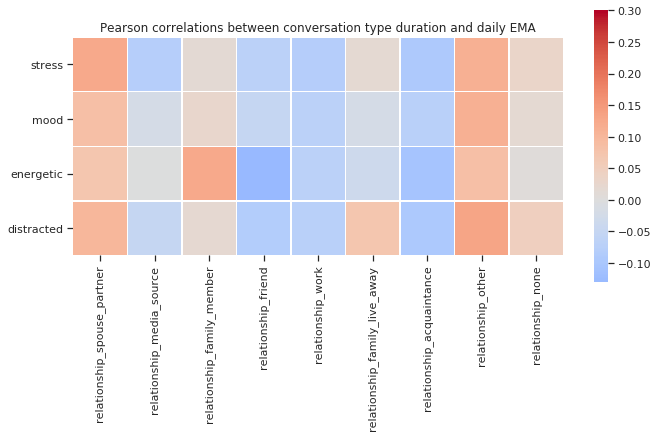

In [192]:
convo_dur = sloc_voice.copy()
for rel in rel_cols:
    convo_dur[rel] = (convo_dur[rel] * convo_dur['duration']).dt.total_seconds() / 60

convo_dur = convo_dur.groupby(["pid", "start_date"], as_index=False)[rel_cols].sum(axis=1)
convo_dur = convo_dur.rename({"start_date": "date"}, axis='columns')

convo_dur = convo_dur.merge(ema_df, on=['pid', 'date'], how='left')
convo_dur.drop("date", axis='columns', inplace=True)
convo_dur = convo_dur.groupby("pid").mean()
corr = convo_dur.corr(method='pearson')
corr = corr.iloc[len(rel_cols):, :len(rel_cols)]

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap="coolwarm", center=0, vmax=0.3,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.yticks(rotation=0)
plt.title("Pearson correlations between conversation type duration and daily EMA")

In [193]:
dur_corr_details = pg.pairwise_corr(data=convo_dur, method="pearson", padjust="fdr_bh")
dur_corr_details[(dur_corr_details['Y'].isin(emas)) & (dur_corr_details['p-corr'] < 0.05) & (~dur_corr_details['X'].isin(emas))]

,X,Y,method,tail,n,r,CI95%,r2,adj_r2,z,p-unc,p-corr,p-adjust,BF10,power


### Spearman

Text(0.5, 1, 'spearman correlations between conversation type duration and daily EMA')

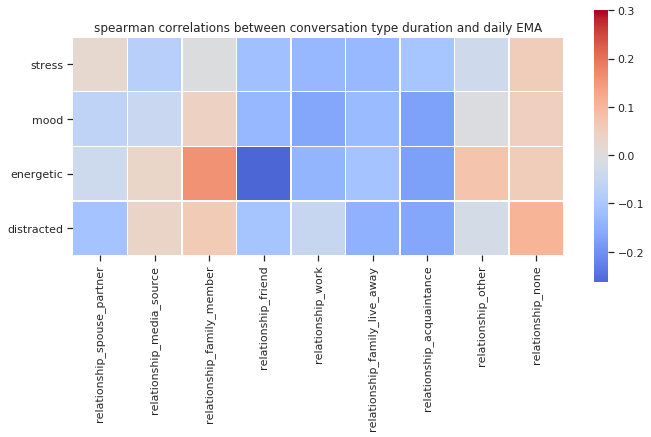

In [194]:
convo_dur = sloc_voice.copy()
for rel in rel_cols:
    convo_dur[rel] = (convo_dur[rel] * convo_dur['duration']).dt.total_seconds() / 60

convo_dur = convo_dur.groupby(["pid", "start_date"], as_index=False)[rel_cols].sum(axis=1)
convo_dur = convo_dur.rename({"start_date": "date"}, axis='columns')

convo_dur = convo_dur.merge(ema_df, on=['pid', 'date'], how='left')
convo_dur.drop("date", axis='columns', inplace=True)
convo_dur = convo_dur.groupby("pid").mean()
corr = convo_dur.corr(method='spearman')
corr = corr.iloc[len(rel_cols):, :len(rel_cols)]

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap="coolwarm", center=0, vmax=0.3,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.yticks(rotation=0)
plt.title("spearman correlations between conversation type duration and daily EMA")

In [195]:
dur_corr_details = pg.pairwise_corr(data=convo_dur, method="spearman", padjust="fdr_bh")
dur_corr_details[(dur_corr_details['Y'].isin(emas)) & (dur_corr_details['p-corr'] < 0.05) & (~dur_corr_details['X'].isin(emas))]

,X,Y,method,tail,n,r,CI95%,r2,adj_r2,z,p-unc,p-corr,p-adjust,power
40,relationship_friend,energetic,spearman,two-sided,136,-0.263,"[-0.41, -0.1]",0.069,0.055,-0.269,0.001967,0.017044,fdr_bh,0.877


# Notes

## Study Schedule

- [link](https://docs.google.com/spreadsheets/d/1gM0tQnltc9pOMy1mouwrfw0o1Mi5ALQHh_l8-O_MUJw/edit#gid=176032971)

### start/end dates

- wk 1: 2/11 - 2/17
- wk 4: 3/3 - 3/9
- wk 7: 3/24 - 3/30
- wk 10: 4/14 - 4/20
- wk 13: 5/5 - 5/11


## voice relationship dataframe

- want to convert ema and phq into "voice_relationship" dataframe:
    - three columns: relationship, start time, end time, conversation length
    
- the "other" column is always present, but only populated when the individual provides a label
    - looks like we can safely remove the "other" only rows from the DataFrame
    
- predefined relationship categories:
    - spouse_partner
    - media_source
    - none
    - family_member
    - friend
    - work
    - family_live_away
    - acquaintance
    - other

## VAD dataframe